In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def adaptive_non_maximal_suppression(keypoints, max_keypoints):
    
    if len(keypoints) <= max_keypoints:
        return keypoints

    # Sort keypoints by their response scores in descending order
    keypoints = sorted(keypoints, key=lambda x: -x.response)

    # Initialize an empty list to store the selected keypoints
    selected_keypoints = [keypoints[0]]

    for i in range(1, len(keypoints)):
        
        min_distance = float('inf')

        for j in range(len(selected_keypoints)):

            # Calculate the Euclidean distance between the current keypoint and selected keypoints
            distance = np.sqrt((keypoints[i].pt[0] - selected_keypoints[j].pt[0])**2 + 
                               (keypoints[i].pt[1] - selected_keypoints[j].pt[1])**2)

            # update the minimum distance
            if distance < min_distance:
                min_distance = distance

        # Use the threshold to select keypoints
        if min_distance >= 10:
            selected_keypoints.append(keypoints[i])

    return selected_keypoints

In [3]:
def detect_features(img1, img2, algorithm='SIFT'):

    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Feature Detection and Matching
    if algorithm=='SIFT':

        sift = cv2.SIFT_create()

        keypoints1 = sift.detect(gray1, None)
        keypoints2 = sift.detect(gray2, None)

        max_keypoints = 100

        # Using adaptive non-maximal suppression to improve feature detection
        selected_keypoints1 = adaptive_non_maximal_suppression(keypoints1, max_keypoints)
        selected_keypoints2 = adaptive_non_maximal_suppression(keypoints2, max_keypoints)

        # Describe the features
        selected_keypoints1, descriptors1 = sift.compute(gray1, selected_keypoints1, None)
        selected_keypoints2, descriptors2 = sift.compute(gray2, selected_keypoints2, None)

        
    elif algorithm=='ORB':

        orb = cv2.ORB_create()
        
        keypoints1 = orb.detect(gray1, None)
        keypoints2 = orb.detect(gray2, None)

        max_keypoints = 100

        # Using adaptive non-maximal suppression to improve feature detection
        selected_keypoints1 = adaptive_non_maximal_suppression(keypoints1, max_keypoints)
        selected_keypoints2 = adaptive_non_maximal_suppression(keypoints2, max_keypoints)

        # Describe the features
        selected_keypoints1, descriptors1 = orb.compute(gray1, selected_keypoints1, None)
        selected_keypoints2, descriptors2 = orb.compute(gray2, selected_keypoints2, None)
    
    else:
        print("detector not implemented!")
        exit()

    # Standardize the features
    mean1 = np.mean(descriptors1, axis=0)
    std1 = np.mean(descriptors1, axis=0)
    standardized_descriptors1 = (descriptors1 - mean1)/std1

    mean2 = np.mean(descriptors2, axis=0)
    std2 = np.mean(descriptors2, axis=0)
    standardized_descriptors2 = (descriptors2 - mean2)/std2

    return selected_keypoints1, selected_keypoints2, standardized_descriptors1, standardized_descriptors2


In [12]:
def match_features(descriptors1, descriptors2, threshold=0.5):

    # Feature Matching
    # cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
    bf = cv2.BFMatcher()

    # if descriptors1 is None:
    #     print('Descriptors1 is None')
    #     exit()

    # if descriptors2 is None:
    #     print('Descriptors2 is None')
    #     exit()

    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # define the minimum count of matches
    # MIN_MATCH_COUNT = 10
    
    # Apply Lowe's ratio test to select good matches
    good_matches = []
    for m, n in matches:
        if m.distance < threshold * n.distance:
            good_matches.append(m)

    match_rate = len(good_matches) / len(matches)

    # Print count of good matches
    # print(len(good_matches))

    return good_matches, match_rate

In [5]:
def recover_homography(keypoints1, keypoints2, good_matches):

    # Robust Recovery of Homography using RANSAC
    dst_left = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_right = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(dst_left, dst_right, cv2.RANSAC, 5.0)
    matches_mask = mask.ravel().tolist()

    return H, mask, matches_mask

In [6]:
def image_stitching(img_left, img_right, H):

    # Convert BGR format to RGB format
    img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
    img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)

    # Image Stitching
    # Normalize images to avoid noise.
    img_left = cv2.normalize(img_left.astype('float'), None, 
                            0.0, 1.0, cv2.NORM_MINMAX)   
    img_right = cv2.normalize(img_right.astype('float'), None, 
                            0.0, 1.0, cv2.NORM_MINMAX)   
    
    # left image
    height_l, width_l, _ = img_left.shape
    corners = [[0, 0, 1], [width_l, 0, 1], [width_l, height_l, 1], [0, height_l, 1]]
    corners_new = [np.dot(H, corner) for corner in corners]
    corners_new = np.array(corners_new).T 
    x_news = corners_new[0] / corners_new[2]
    y_news = corners_new[1] / corners_new[2]
    y_min = min(y_news)
    x_min = min(x_news)

    translation_mat = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
    H = np.dot(translation_mat, H)
    
    # Get height, width
    height_new = int(round(abs(y_min) + height_l))
    width_new = int(round(abs(x_min) + width_l))
    dsize = (width_new, height_new)

    warped_l = cv2.warpPerspective(img_left, H, dsize)


    # right image

    height_r, width_r, _ = img_right.shape
    
    height_new = int(round(abs(y_min) + height_r))
    width_new = int(round(abs(x_min) + width_r))
    dsize = (width_new, height_new)
    

    warped_r = cv2.warpPerspective(img_right, translation_mat, dsize)
     
    pixel_black = [0, 0, 0]  # Black pixel.
    
    # Stitching procedure, store results in warped_l.
    for i in range(warped_r.shape[0]):
        for j in range(warped_r.shape[1]):
            pixel_l = warped_l[i, j, :]
            pixel_r = warped_r[i, j, :]
            
            if not np.array_equal(pixel_l, pixel_black) and np.array_equal(pixel_r, pixel_black):
                warped_l[i, j, :] = pixel_l
            elif np.array_equal(pixel_l, pixel_black) and not np.array_equal(pixel_r, pixel_black):
                warped_l[i, j, :] = pixel_r
            elif not np.array_equal(pixel_l, pixel_black) and not np.array_equal(pixel_r, pixel_black):
                warped_l[i, j, :] = (pixel_l + pixel_r) / 2
            else:
                pass
                  
    stitch_image = warped_l[:warped_r.shape[0], :warped_r.shape[1], :]
    return stitch_image

In [17]:
def experiment(img_left, img_right, threshold, algorithm, vis=False):
    if not img_left.shape == img_right.shape:
        img_right = cv2.resize(img_right, (img_left.shape[1], img_left.shape[0]))

    keypoints1, keypoints2, descriptors1, descriptors2 = detect_features(img_left, img_right, algorithm=algorithm)
    descriptors1 = descriptors1.astype(np.uint8)
    descriptors2 = descriptors2.astype(np.uint8)
    good_matches, match_rate = match_features(descriptors1, descriptors2, threshold=threshold)
    H, mask, matches_mask = recover_homography(keypoints1, keypoints2, good_matches)

    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                       singlePointColor = None,
                       matchesMask = matches_mask, # draw only inliers
                       flags = 2)
    
    mask_img = cv2.drawMatches(img_left, keypoints1, img_right, keypoints2, good_matches, None, **draw_params)

    print('The count of matches is {} and the match rate is {}'.format(len(good_matches), match_rate))

    if vis:
        result = image_stitching(img_left, img_right, H)
        plt.figure(figsize=(20, 10), dpi=300)
        plt.subplot(1, 2, 1)
        plt.title('(a) panorama image')
        plt.imshow(result)
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(mask_img, cv2.COLOR_BGR2RGB))
        plt.title('(b) matched image (match rate:{:.4f})'.format(match_rate))
        plt.show()

The count of matches is 12 and the match rate is 0.13636363636363635


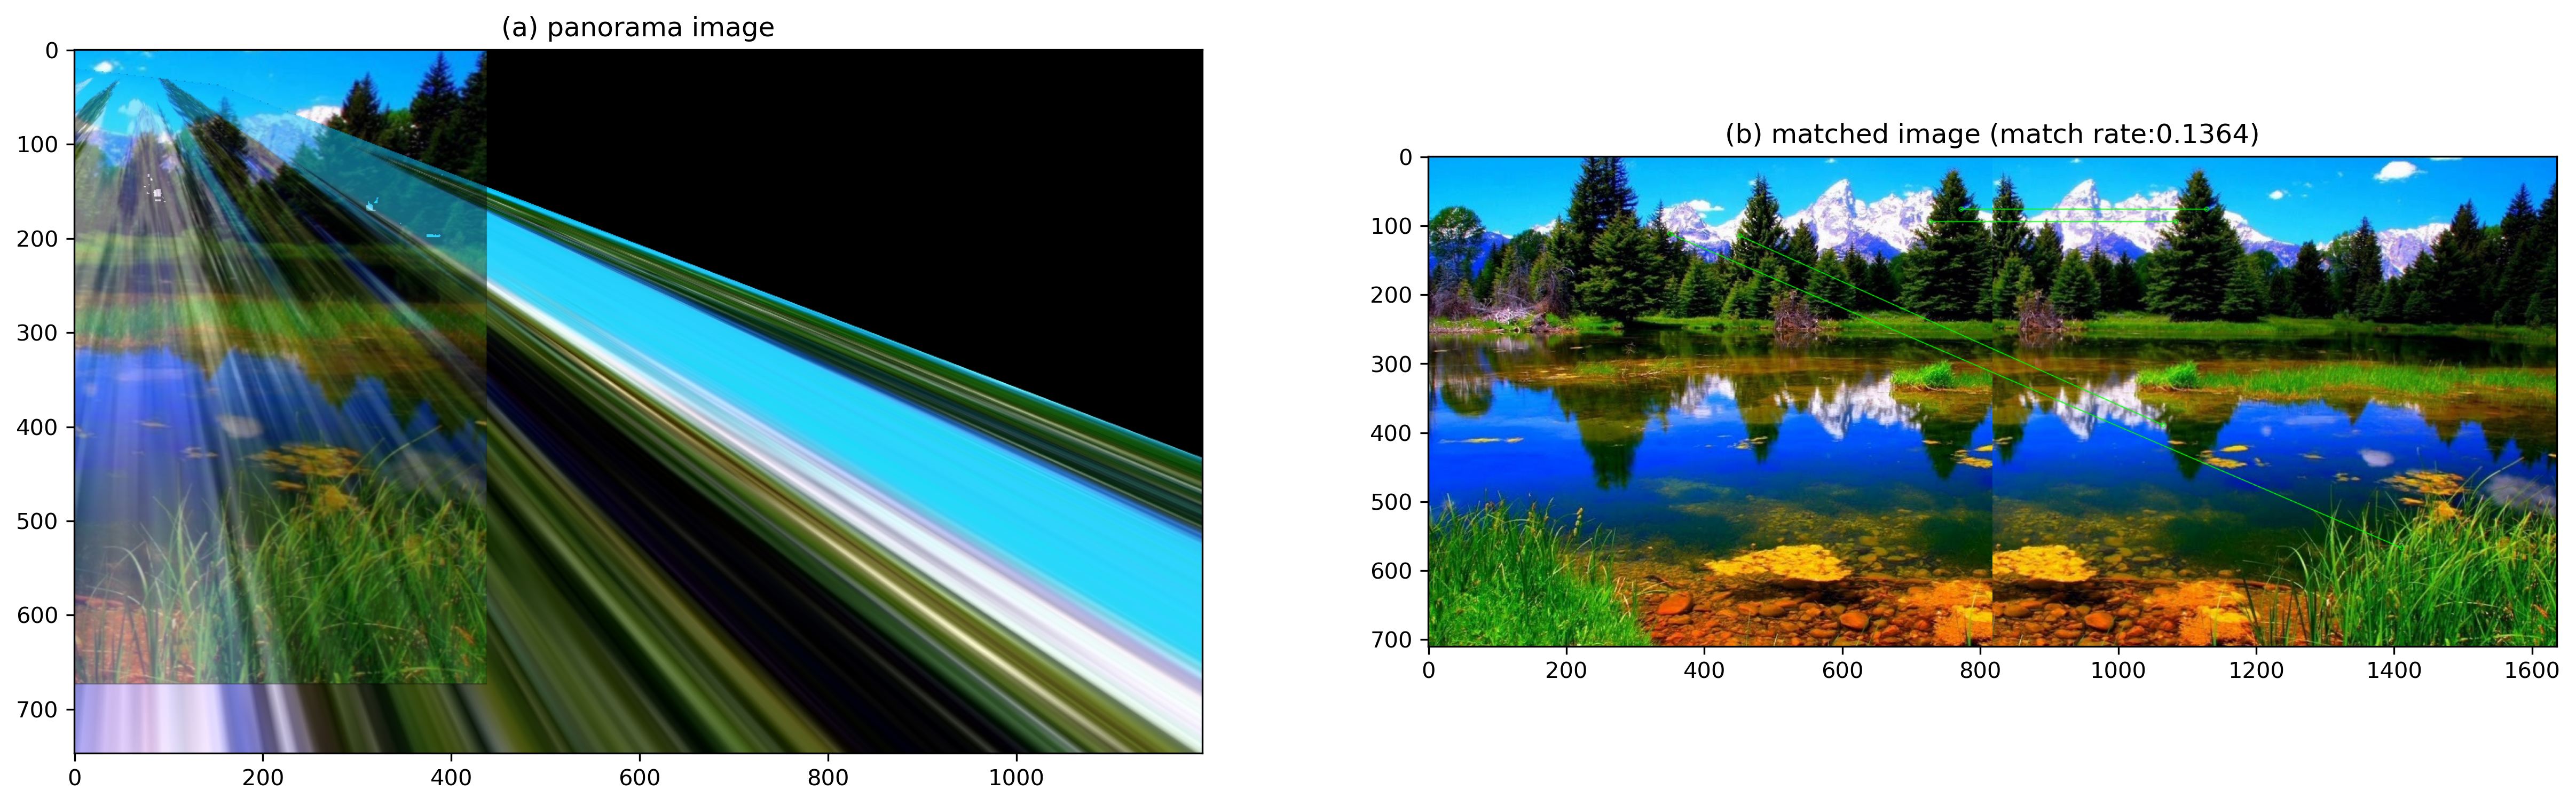

In [33]:
img_left = cv2.imread('image_pairs/image_pairs_01_01.jpg')
img_right = cv2.imread('image_pairs/image_pairs_01_02.jpg')
experiment(img_left, img_right, 1, 'ORB', vis=True)

In [8]:
# load 
base_path = 'image_pairs/'
img_left_list = ['image_pairs_01_01.jpg', 'image_pairs_02_02.png', 'image_pairs_03_01.jpg', 'image_pairs_04_01.jpg']
img_right_list = ['image_pairs_01_02.jpg', 'image_pairs_02_01.png', 'image_pairs_03_02.jpg', 'image_pairs_04_02.jpg']
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

for i in range(0, len(img_left_list)):
    img_left = cv2.imread(base_path + img_left_list[i])
    img_right = cv2.imread(base_path + img_right_list[i])

    for threshold in thresholds:
        
        # Do the experiment with SIFT algorithm
        print('Stitch image {} and {} when threshold = {} using SIFT ... '.format(img_left_list[i], img_right_list[i], threshold))
        try:
            experiment(img_left, img_right, threshold, 'SIFT', vis=False)
        except:
            print('No enough matches for {} and {} when threshold = {} using SIFT'.format(img_left_list[i], img_right_list[i], threshold))

        # Do the experiment with ORB algorithm
        print('Stitch image {} and {} when threshold = {} using ORB ... '.format(img_left_list[i], img_right_list[i], threshold))
        try:
            experiment(img_left, img_right, threshold, 'ORB', vis=False)
        except:
            print('No enough matches for {} and {} when threshold = {}'.format(img_left_list[i], img_right_list[i], threshold))
        
        


Stitch image image_pairs_01_01.jpg and image_pairs_01_02.jpg when threshold = 0.1 using SIFT ... 
The count of matches is 10 and the match rate is 0.001691761123329386
Stitch image image_pairs_01_01.jpg and image_pairs_01_02.jpg when threshold = 0.1 using ORB ... 
No enough matches for image_pairs_01_01.jpg and image_pairs_01_02.jpg when threshold = 0.1
Stitch image image_pairs_01_01.jpg and image_pairs_01_02.jpg when threshold = 0.2 using SIFT ... 
The count of matches is 582 and the match rate is 0.09846049737777025
Stitch image image_pairs_01_01.jpg and image_pairs_01_02.jpg when threshold = 0.2 using ORB ... 
No enough matches for image_pairs_01_01.jpg and image_pairs_01_02.jpg when threshold = 0.2
Stitch image image_pairs_01_01.jpg and image_pairs_01_02.jpg when threshold = 0.3 using SIFT ... 
The count of matches is 1149 and the match rate is 0.19438335307054644
Stitch image image_pairs_01_01.jpg and image_pairs_01_02.jpg when threshold = 0.3 using ORB ... 
No enough matches for 